In [46]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import numpy as np
import matplotlib.pylab as plt
import os
#import time
from datetime import datetime
import io
import sklearn.metrics
import itertools
print(tf.__version__)

2.3.0


In [47]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

In [48]:
# Plain text name in alphabetical order. https://www.cs.toronto.edu/~kriz/cifar.html
CLASS_NAMES = ['airplane', 'automobile', 'bird', 'cat', 
               'deer','dog', 'frog', 'horse', 'ship', 'truck']

In [49]:
train_labels_array = np.squeeze(train_labels)

In [50]:
validation_dataset = tf.data.Dataset.from_tensor_slices((test_images[:500], test_labels[:500]))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images[500:], test_labels[500:]))

In [51]:
# Create an instance of dataset from raw numpy images and labels.
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))

In [52]:
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset#transformations_2
train_dataset_size = len(list(train_dataset.as_numpy_iterator()))
print('Training data sample size: ', train_dataset_size)
test_dataset_size = len(list(test_dataset.as_numpy_iterator()))
print('Test data sample size: ', test_dataset_size)

Training data sample size:  50000
Test data sample size:  9500


In [53]:
TRAIN_BATCH_SIZE = 200
train_dataset = train_dataset.shuffle(50000).batch(TRAIN_BATCH_SIZE, drop_remainder=True)

In [54]:
validation_dataset = validation_dataset.batch(500)
test_dataset = test_dataset.batch(test_dataset_size)

In [55]:
STEPS_PER_EPOCH = train_dataset_size // TRAIN_BATCH_SIZE
VALIDATION_STEPS = 1 #validation data // validation batch size

In [56]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', name = 'conv_1',
      kernel_initializer='glorot_uniform', padding='same', input_shape = (32,32,3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', name = 'conv_2',
      kernel_initializer='glorot_uniform', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', name = 'conv_3',
      kernel_initializer='glorot_uniform', padding='same'),
    tf.keras.layers.Flatten(name = 'flat_1',),
    tf.keras.layers.Dense(64, activation='relu', kernel_initializer='glorot_uniform', name = 'dense_64'),
    tf.keras.layers.Dense(10, activation='softmax', name = 'custom_class')
])
model.build([None, 32, 32, 3])

In [57]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 8, 8, 64)          36928     
_________________________________________________________________
flat_1 (Flatten)             (None, 4096)              0         
_________________________________________________________________
dense_64 (Dense)             (None, 64)               

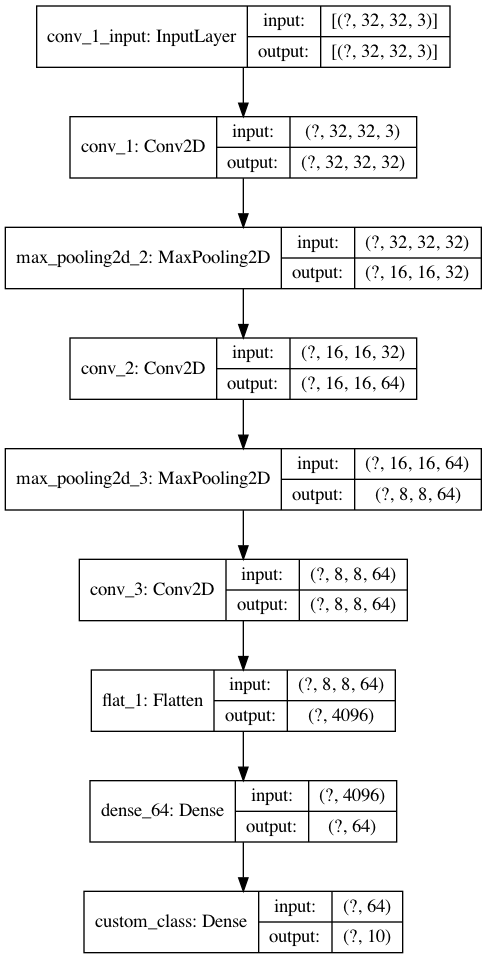

In [58]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [59]:
model.compile(
          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
          optimizer='adam',
          metrics=['accuracy'])

In [60]:
MODEL_NAME = 'myCIFAR10-{}'.format(datetime.now().strftime("%Y%m%d-%H%M%S"))
print(MODEL_NAME)

myCIFAR10-20210124-135804


In [61]:
checkpoint_dir = './' + MODEL_NAME
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt-{epoch}")
print(checkpoint_prefix)

./myCIFAR10-20210124-135804/ckpt-{epoch}


In [62]:
checkpoint_prefix

'./myCIFAR10-20210124-135804/ckpt-{epoch}'

In [63]:
myCheckPoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    monitor='val_accuracy',
    mode='max')

In [64]:
myTensorBoard = tf.keras.callbacks.TensorBoard(log_dir='./tensorboardlogs/{}'.format(MODEL_NAME),
                  write_graph=True, write_images=True, histogram_freq=1)
myCallbacks = [
    myCheckPoint,
    myTensorBoard
]

In [65]:
!tensorboard --logdir='./tensorboardlogs/'

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.3.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [66]:
hist = model.fit(
    train_dataset,
    epochs=30,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_dataset,
    validation_steps=VALIDATION_STEPS,
    callbacks=myCallbacks).history

Epoch 1/30
250/250 [==============================] - 21s 84ms/step - loss: 2.1271 - accuracy: 0.3252 - val_loss: 2.0659 - val_accuracy: 0.3780
Epoch 2/30
250/250 [==============================] - 21s 84ms/step - loss: 1.9985 - accuracy: 0.4616 - val_loss: 1.9662 - val_accuracy: 0.4800
Epoch 3/30
250/250 [==============================] - 21s 82ms/step - loss: 1.9340 - accuracy: 0.5282 - val_loss: 1.9370 - val_accuracy: 0.5260
Epoch 4/30
250/250 [==============================] - 20s 79ms/step - loss: 1.8915 - accuracy: 0.5704 - val_loss: 1.8977 - val_accuracy: 0.5620
Epoch 5/30
250/250 [==============================] - 20s 78ms/step - loss: 1.8614 - accuracy: 0.5995 - val_loss: 1.8807 - val_accuracy: 0.5700
Epoch 6/30
250/250 [==============================] - 20s 80ms/step - loss: 1.8312 - accuracy: 0.6306 - val_loss: 1.8380 - val_accuracy: 0.6240
Epoch 7/30
250/250 [==============================] - 20s 80ms/step - loss: 1.8065 - accuracy: 0.6554 - val_loss: 1.8135 - val_accuracy:

Epoch 28/30
250/250 [==============================] - 20s 81ms/step - loss: 1.6134 - accuracy: 0.8496 - val_loss: 1.7389 - val_accuracy: 0.7240
Epoch 29/30
250/250 [==============================] - 20s 81ms/step - loss: 1.6112 - accuracy: 0.8519 - val_loss: 1.7461 - val_accuracy: 0.7120
Epoch 30/30
250/250 [==============================] - 20s 81ms/step - loss: 1.6029 - accuracy: 0.8601 - val_loss: 1.7307 - val_accuracy: 0.7280


In [68]:
hist['val_accuracy']

[0.3779999911785126,
 0.47999998927116394,
 0.5260000228881836,
 0.5619999766349792,
 0.5699999928474426,
 0.6240000128746033,
 0.6460000276565552,
 0.6620000004768372,
 0.6579999923706055,
 0.6740000247955322,
 0.6819999814033508,
 0.6940000057220459,
 0.6740000247955322,
 0.6800000071525574,
 0.6919999718666077,
 0.699999988079071,
 0.7080000042915344,
 0.7099999785423279,
 0.6959999799728394,
 0.6880000233650208,
 0.7400000095367432,
 0.734000027179718,
 0.7139999866485596,
 0.7080000042915344,
 0.7300000190734863,
 0.7099999785423279,
 0.722000002861023,
 0.7239999771118164,
 0.7120000123977661,
 0.7279999852180481]

In [69]:
max_value = max(hist['val_accuracy'])
max_index = hist['val_accuracy'].index(max_value)
print('Best epoch: ', max_index + 1)

Best epoch:  21


In [70]:
os.listdir(checkpoint_dir)

['ckpt-5',
 'ckpt-2',
 'ckpt-3',
 'ckpt-4',
 'ckpt-10',
 'ckpt-28',
 'ckpt-17',
 'ckpt-21',
 'ckpt-19',
 'ckpt-26',
 'ckpt-18',
 'ckpt-27',
 'ckpt-20',
 'ckpt-29',
 'ckpt-16',
 'ckpt-11',
 'ckpt-30',
 'ckpt-8',
 'ckpt-1',
 'ckpt-6',
 'ckpt-7',
 'ckpt-9',
 'ckpt-14',
 'ckpt-13',
 'ckpt-25',
 'ckpt-22',
 'ckpt-23',
 'ckpt-24',
 'ckpt-12',
 'ckpt-15']

In [ ]:
!tensorboard --logdir='./tensorboardlogs/'

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.3.0 at http://localhost:6007/ (Press CTRL+C to quit)


In [25]:
for layer in model.layers:
  print(layer.name, layer)

conv_1 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb790d40fd0>
max_pooling2d <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fb77089c3d0>
conv_2 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb77089c700>
max_pooling2d_1 <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fb77089cb80>
conv_3 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb77089ceb0>
flat_1 <tensorflow.python.keras.layers.core.Flatten object at 0x7fb7708dd340>
dense_64 <tensorflow.python.keras.layers.core.Dense object at 0x7fb7708dd5b0>
custom_class <tensorflow.python.keras.layers.core.Dense object at 0x7fb7708dd940>


In [32]:
model.layers[-1]

In [33]:
print(model.layers[-1].weights)

[<tf.Variable 'custom_class/kernel:0' shape=(64, 10) dtype=float32, numpy=
array([[ 1.55364901e-01, -2.08042473e-01, -2.82124847e-01,
        -2.49712676e-01, -9.95742232e-02, -1.82019502e-01,
         2.34590486e-01, -2.52632707e-01, -8.43587052e-03,
         2.19245162e-02],
       [-2.82783717e-01, -2.62977511e-01, -5.48943460e-01,
        -3.71428400e-01, -8.71202648e-02,  3.08227360e-01,
        -1.41886875e-01,  2.11541131e-01,  3.06587853e-02,
        -1.95460081e-01],
       [ 3.00249875e-01,  3.20867077e-02, -2.86882162e-01,
         1.14302553e-01,  4.38867271e-01, -1.17358901e-01,
        -3.27088714e-01, -2.13418409e-01,  3.39652091e-01,
        -4.18735202e-03],
       [ 1.86309367e-01,  2.92876437e-02, -1.80092543e-01,
        -3.16526331e-02, -2.60737807e-01, -2.29673967e-01,
         1.24184623e-01,  5.18185878e-03, -2.18327940e-01,
        -1.29951537e-01],
       [ 1.20458998e-01,  2.29231507e-01, -2.69157141e-01,
        -5.37790716e-01, -5.40434904e-02,  8.77316445e

In [34]:
prediction_batch = model.predict(test_dataset)

In [35]:
prediction_batch[0]

array([1.1398206e-19, 2.9104240e-11, 8.1870510e-09, 1.8728900e-13,
       1.2758862e-04, 5.5517641e-18, 9.9987245e-01, 1.9912129e-11,
       1.8693531e-17, 1.9803946e-12], dtype=float32)

In [36]:
prediction_batch_idx = np.argmax(prediction_batch, axis = 1)

In [37]:
prediction_batch_idx
prediction_batch_idx.shape

(9500,)

In [38]:
truth_idx = []
for img, truth in test_dataset.take(test_dataset_size):
    truth_idx.append(truth)

In [39]:
truth = np.array(truth_idx)

In [40]:
tr = truth.squeeze()

In [41]:
tr.shape

(9500,)

In [42]:
 # Calculate the confusion matrix.
cm = sklearn.metrics.confusion_matrix(tr, prediction_batch_idx)

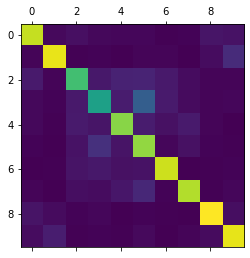

In [43]:
import matplotlib.pyplot as plt 
plt.matshow(cm)  

In [44]:
def plot_confusion_matrix(cm, class_names):
  """
  Returns a matplotlib figure containing the plotted confusion matrix.

  Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
  """
  figure = plt.figure(figsize=(8, 8))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title("Confusion matrix")
  plt.colorbar()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)

  # Compute the labels from the normalized confusion matrix.
  labels = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

  # Use white text if squares are dark; otherwise black.
  threshold = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    color = "white" if cm[i, j] > threshold else "black"
    plt.text(j, i, labels[i, j], horizontalalignment="center", color=color)

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  return figure

def plot_to_image(figure):
  """Converts the matplotlib plot specified by 'figure' to a PNG image and
  returns it. The supplied figure is closed and inaccessible after this call."""
  # Save the plot to a PNG in memory.
  buf = io.BytesIO()
  plt.savefig(buf, format='png')
  # Closing the figure prevents it from being displayed directly inside
  # the notebook.
  plt.close(figure)
  buf.seek(0)
  # Convert PNG buffer to TF image
  image = tf.image.decode_png(buf.getvalue(), channels=4)
  # Add the batch dimension
  image = tf.expand_dims(image, 0)
  return image

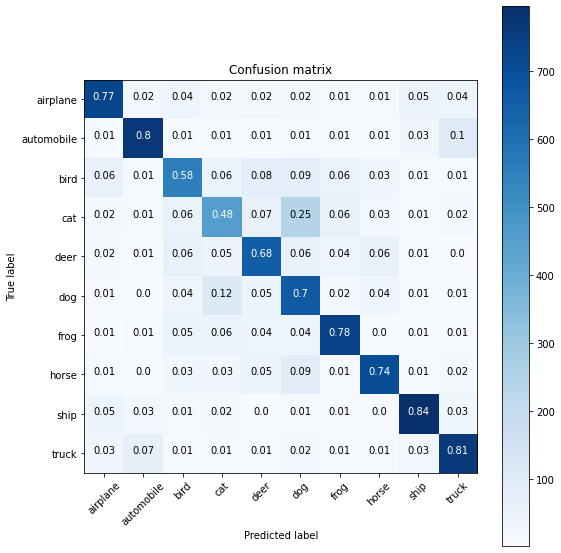

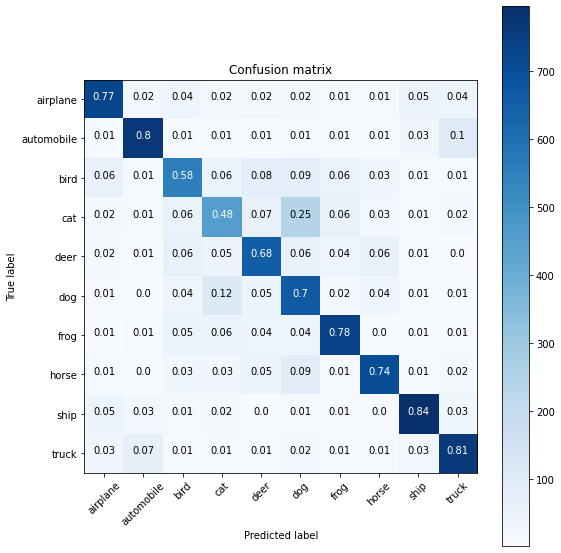

In [45]:
plot_confusion_matrix(cm, class_names=CLASS_NAMES)

In [129]:
# Log the confusion matrix as an image summary.
figure = plot_confusion_matrix(cm, class_names=CLASS_NAMES)
cm_image = plot_to_image(figure)

In [132]:
cm_image

<tf.Tensor: shape=(1, 576, 576, 4), dtype=uint8, numpy=
array([[[[255, 255, 255,   0],
         [255, 255, 255,   0],
         [255, 255, 255,   0],
         ...,
         [255, 255, 255,   0],
         [255, 255, 255,   0],
         [255, 255, 255,   0]],

        [[255, 255, 255,   0],
         [255, 255, 255,   0],
         [255, 255, 255,   0],
         ...,
         [255, 255, 255,   0],
         [255, 255, 255,   0],
         [255, 255, 255,   0]],

        [[255, 255, 255,   0],
         [255, 255, 255,   0],
         [255, 255, 255,   0],
         ...,
         [255, 255, 255,   0],
         [255, 255, 255,   0],
         [255, 255, 255,   0]],

        ...,

        [[255, 255, 255,   0],
         [255, 255, 255,   0],
         [255, 255, 255,   0],
         ...,
         [255, 255, 255,   0],
         [255, 255, 255,   0],
         [255, 255, 255,   0]],

        [[255, 255, 255,   0],
         [255, 255, 255,   0],
         [255, 255, 255,   0],
         ...,
         [255, 

In [ ]:
# Log the confusion matrix as an image summary.
with file_writer_cm.as_default():
    tf.summary.image("Confusion Matrix", cm_image, step=epoch)